<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
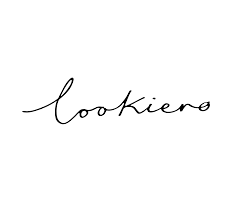    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis final
Se generan gráficos explicativos de los datos procesados

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

- **Pyspark**

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import functions as F
import pyspark.sql.functions as f
from pyspark.sql.functions import lit, trim, split, regexp_replace, when

- **Strings**

In [3]:
from collections import Counter
import re

- **Visualización**

In [4]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
import torch

* **Grafos**

In [6]:
import networkx as nx

- **Otros**

In [7]:
import itertools

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [8]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [9]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        try: 
            path = os.getcwd()
            csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []
            for i in csv_files:
                temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
                dataframes_list.append(temp_df)
  
        except: pass
            
        return dataframes_list
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

cd = carga_datos ()

In [10]:
df = spark.read.csv(dir_out + 'lookiero_*.csv', header=True, inferSchema=True)
df_total = spark.read.csv(dir_out + 'df_total.csv', header=True, inferSchema=True)
dfs = cd.subir_tablas(dir_in)

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [11]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [12]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [13]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

### Gráficos
---

In [14]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

paleta = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']

#### **Estaciones**

In [15]:
season_collection = dfs[-3].select('season').collect()
season = np.array([x[0] for x in season_collection])
count_values = np.bincount(season)[-3:]

fig = go.Figure(data=[go.Bar( x=count_values, y=['7', '8', '9'],text=count_values,textposition='auto',texttemplate = [human_format(a) for a in count_values],orientation='h')])
fig.update_traces(marker_color=[paleta[0], paleta[1], paleta[0]],marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Estaciones más frecuente Lookiero',
    xaxis_title = 'Cantidad',
    yaxis_title = 'Estaciones', 
    # width=2280, height=950, font = dict(size = 22),
    paper_bgcolor='white',
    plot_bgcolor='white', 
    xaxis_range=[20000,23000]
)

#### **Familias de producto**

In [16]:
product_family = df_total.select('family_product').collect()
product_family = np.array([x[0] for x in product_family])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

In [17]:
colores = [paleta[1]] * 3 + [paleta[0]] * (len(counts_elements) - 9) + [paleta[6]] * 6
fig = go.Figure(data=[go.Bar( x=unique_elements, y=counts_elements,text=count_values,textposition='auto',texttemplate = [human_format(a) for a in counts_elements], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos más populares',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    # width=2280, height=950, font = dict(size = 22),
    paper_bgcolor='white',
    plot_bgcolor='white')


#### **Size percentaje**

In [18]:
size_lookiero = df_total.select('size_lookiero').collect()
size_lookiero = np.array([x[0] for x in size_lookiero])

unique_elements, counts_elements = np.unique(size_lookiero, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))
counts_elements, unique_elements = np.array(counts_elements), np.array(unique_elements)
counts_elements = (counts_elements / counts_elements.sum()) * 100

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = unique_elements


fig = make_subplots(rows = 1, cols = 2, specs = [[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels = labels, values = counts_elements, marker_colors = paleta), 1, 1)

fig.update_traces(hole = .4, hoverinfo = "label + percent + name")

fig.update_layout(
    title_text="Cantidad de productos por tamaño",
    font = dict(size = 12),
    annotations = [dict(text = 'Tallas', x = 0.205, y = 0.5, 
    font_size = 16, showarrow = False
    )])
fig.show()

In [20]:
# save fig as html
fig.write_html(dir_out +'tallas_lookiero.html')

#### **Tallas - Productos**

In [20]:
tallas = df_total.select('size_lookiero').collect()
tallas = np.array([x[0] for x in tallas])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family'] = tallas, product_family

hm_131_p = pd.get_dummies(df_heat, columns=['product_family']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_', '').capitalize() for x in hm_131_p.columns]

In [32]:
print(list(hm_131_p.columns))

['Bag', 'Cardigan', 'Coat', 'Dress', 'Jacket', 'Jeans', 'Jumpsuit', 'Pant', 'Parka', 'Scarf', 'Shirt', 'Short', 'Skirt', 'Sweater', 'Sweatshirt', 'Top', 'Trench', 'Tshirt']


In [33]:
print(list(hm_131_p.index[::-1]))

['XXXL', 'XXS', 'XXL', 'XS', 'XL', 'X4XL', 'UNQ', 'S', 'M', 'L']


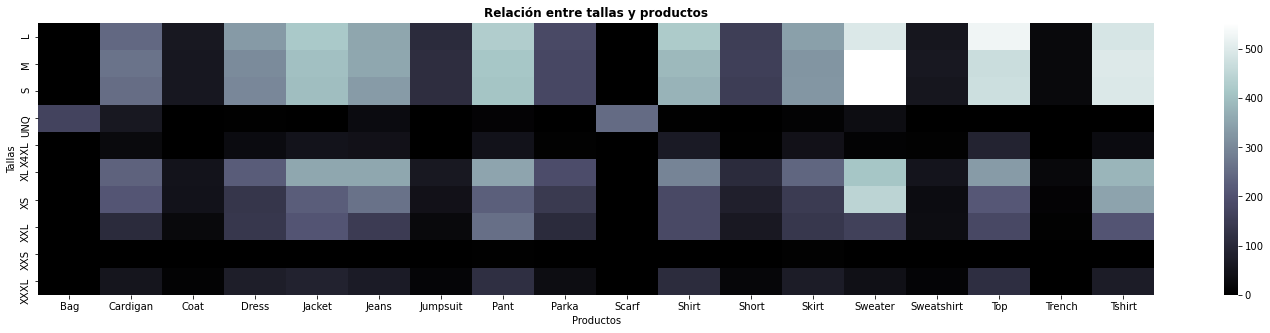

In [21]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p, cmap = 'bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre tallas y productos", fontweight = 'bold');

#### **Tallas - Productos binario**

In [23]:
hm_131_p_scatter = hm_131_p.reset_index()
hm_131_p_scatter_binary = hm_131_p_scatter.copy()
hm_131_p_scatter_binary.iloc[:,1:] = hm_131_p_scatter_binary.iloc[:,1:][hm_131_p_scatter_binary.iloc[:,1:] <= 0].fillna(1)
hm_131_p_scatter_binary.iloc[:,1:] = np.where(hm_131_p_scatter_binary.iloc[:,1:] <= 0, False, True)

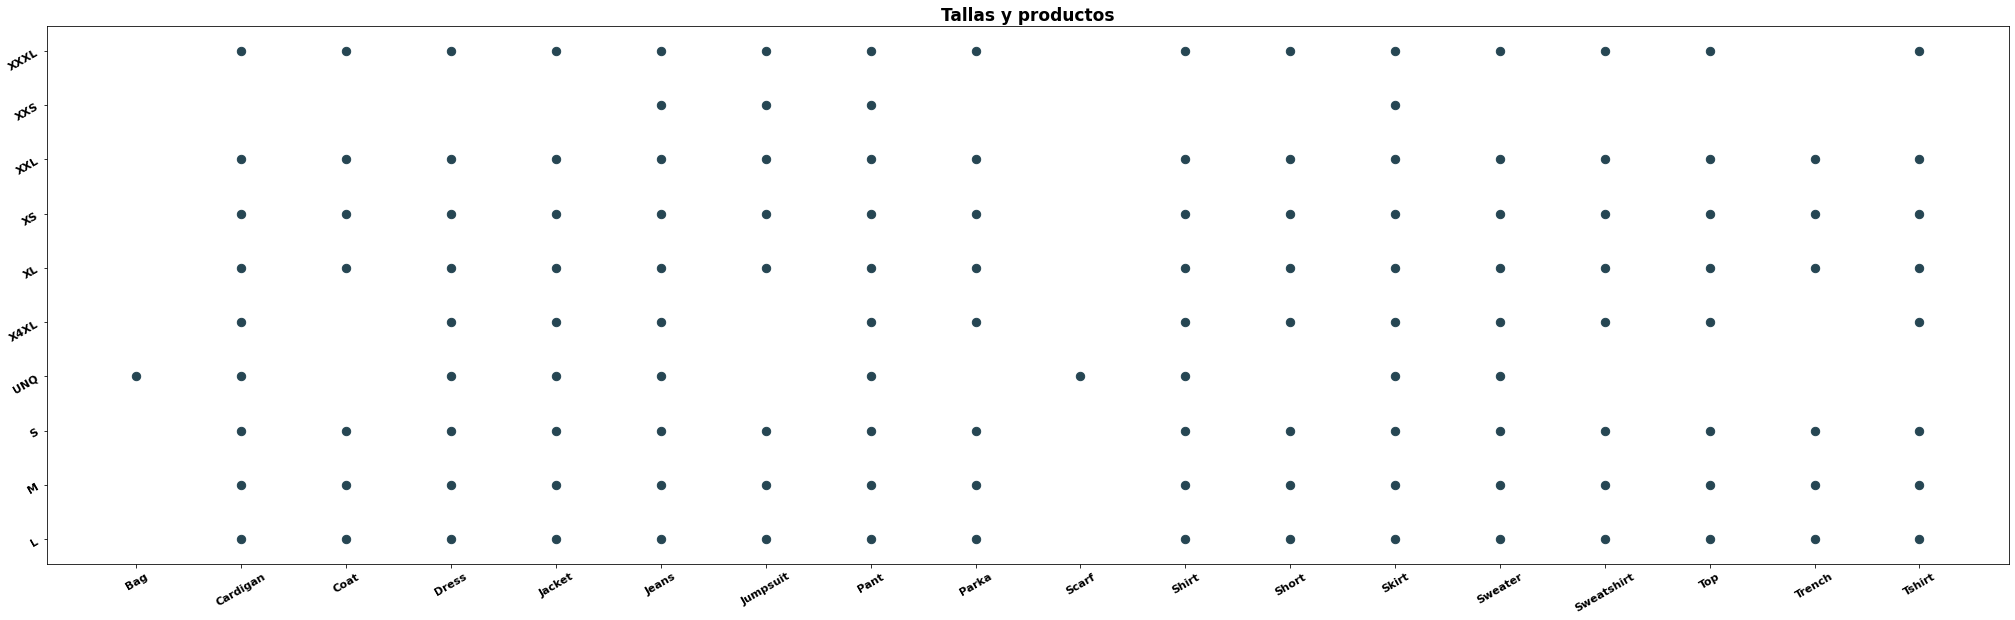

In [24]:
fig, ax = plt.subplots(figsize=(28,8))
for idx, gene in enumerate(hm_131_p_scatter_binary.columns[1:]):
    df_gene = hm_131_p_scatter_binary[[gene, 'size']]
    cList = [paleta[0] if x == True else 'white' for x in df_gene[gene]]
    for inr_idx, lv in enumerate(hm_131_p_scatter_binary['size']):
        ax.scatter(x=idx, y=lv, c=cList[inr_idx], s=70)

fig.tight_layout()
ax.set_title('Tallas y productos', fontsize =  17, weight = 'bold')
plt.yticks([i for i in range(len(hm_131_p_scatter_binary['size']))], list(hm_131_p_scatter_binary['size']))
plt.xticks([i for i in range(len(hm_131_p_scatter_binary.columns)-1)], list(hm_131_p_scatter_binary.columns[1:]))

props = {"rotation" : 30, "fontsize": 11, 'weight': 'bold'}
plt.setp(ax.get_xticklabels(), **props) 
plt.setp(ax.get_yticklabels(), **props)
plt.show()

#### **Empresas con mayor stock**

In [34]:
empresas = df_total.select('name_brand').collect()
empresas = np.array([x[0] for x in empresas])
stock = np.array([x[0] for x in df_total.select('stock').collect()])

In [26]:
df_empresas_stock = pd.DataFrame()
df_empresas_stock['empresas'], df_empresas_stock['stock'] = empresas, stock
top_10_empresas = df_empresas_stock.groupby('empresas').agg({'stock':'sum'}).sort_values(by='stock', ascending=False).head(10).reset_index()
valores = df_empresas_stock.groupby('empresas').agg({'stock':'sum'}).sort_values(by='stock', ascending=False).head(10)
errors = df_empresas_stock.groupby('empresas').agg({'stock':'std'}).sort_values(by='stock', ascending=False).head(10)

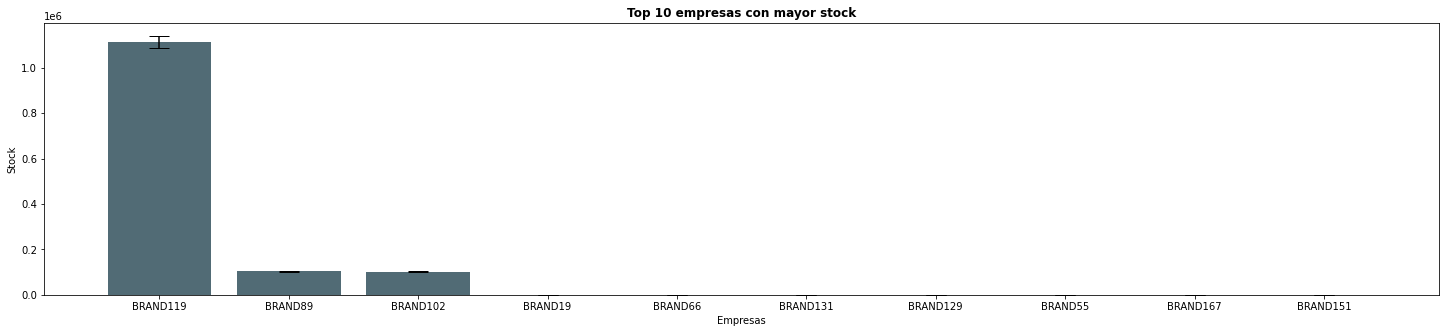

In [27]:
fig, ax = plt.subplots(figsize = (25,5))

ax.bar(valores.index, valores.stock, yerr=errors.stock, align='center', alpha=0.8, ecolor='black', capsize=10, color = paleta[0])
ax.set_facecolor('white')
plt.title('Top 10 empresas con mayor stock', fontweight='bold')
plt.xlabel('Empresas')
plt.ylabel('Stock')
plt.show()

Viendo que muchas empresas no se puede ver el stock que tiene, se decide generar otro gráfico para ver más en detalle el stock de esas empresas.

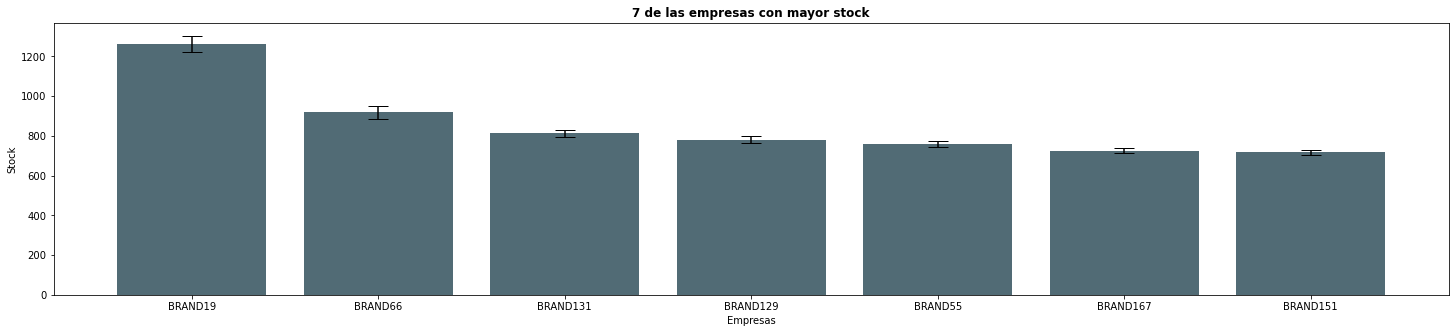

In [28]:
fig, ax = plt.subplots(figsize = (25,5))

ax.bar(valores.index[3:], valores.stock[3:], yerr=errors.stock[3:], align='center', alpha=0.8, ecolor='black', capsize=10, color = paleta[0])
ax.set_facecolor('white')
plt.title('7 de las empresas con mayor stock', fontweight='bold')
plt.xlabel('Empresas')
plt.ylabel('Stock')
plt.show()

#### **Productos más vendidos y origin**

In [35]:
product_family = df_total.select('family_product').collect()
product_family = np.array([x[0] for x in product_family])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

In [36]:
product_family_product, brand_origin_brand = np.array([x[0] for x in df_total.select('family_product').collect()]), np.array([x[0] for x in df_total.select('origin_brand').collect()])
df_product_family_product = pd.DataFrame()
df_product_family_product['family_product'], df_product_family_product['origin_brand'] = product_family_product, brand_origin_brand
df_product_family_product = df_product_family_product[df_product_family_product['family_product'].isin(unique_elements[:5])].reset_index(drop = True)

In [37]:
dumificado = pd.get_dummies(df_product_family_product, columns=['family_product']).groupby(['origin_brand']).sum().reset_index()
dumificado.columns = [dumificado.columns[0]] + [x.replace('family_product_', '').capitalize() for x in dumificado.columns[1:]]
for x in range(len(dumificado)): 
    dumificado.iloc[x, 1:] = (dumificado.iloc[x, 1:] / dumificado.iloc[x, 1:].sum() * 100)
    dumificado.iloc[x, 1:] = dumificado.iloc[x,1:].apply(lambda x: x.round(1))

In [38]:
from itertools import cycle

x_data = dumificado.iloc[:, 1:].values

import plotly.graph_objects as go


top_labels = dumificado.columns[1:]
colors = np.array(paleta)[[0, 1, 2, 4, 5]]
y_data = dumificado.iloc[:,0].values

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],orientation='h',marker=dict(color=colors[i],line=dict(color='rgb(248, 248, 249)', width=1))))

fig.update_layout(
    title='Productos más populares y su influencia en el mercado',
    xaxis=dict(
        showgrid=False,showline=False,showticklabels=False,zeroline=False,domain=[0.15, 1]),

    yaxis=dict(
        showgrid=False,showline=False,showticklabels=False,zeroline=False,),
#     width=2280, height=850, font = dict(size = 22),
    barmode='stack',paper_bgcolor='white',plot_bgcolor='white',margin=dict(l=120, r=10, t=140, b=80),showlegend=False,)

annotations = []

for yd, xd in zip(y_data, x_data):

    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,xanchor='right',text=str(yd),font=dict(family='Arial', size=12,color='rgb(67, 67, 67)'),showarrow=False, align='right'))

    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,text=str(xd[0]) + '%',font=dict(family='Arial', size=12,color='rgb(248, 248, 255)'),showarrow=False))

    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,text=top_labels[0],font=dict(family='Arial', size=12,color='rgb(67, 67, 67)'),showarrow=False))
                                
    space = xd[0]
    for i in range(1, len(xd)):
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,text=str(xd[i]) + '%',font=dict(family='Arial', size=12,color='rgb(248, 248, 255)'),showarrow=False))
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,text=top_labels[i],font=dict(family='Arial', size=12,color='rgb(67, 67, 67)'),showarrow=False)) #, textangle=90
            space += xd[i]

fig.update_layout(annotations=annotations)
fig.show()

#### **Puntos**

In [39]:
product_family = np.array([x[0] for x in df_total.select('family_product').collect()])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

color, product_family_product = np.array([x[0] for x in df_total.select('color').collect()]), np.array([x[0] for x in df_total.select('family_product').collect()])
df_color = pd.DataFrame()
df_color['color'], df_color['family_product'] = color, product_family_product

dumificado = pd.get_dummies(df_color, columns=['family_product']).groupby(['color']).sum().reset_index()
dumificado.columns = [dumificado.columns[0]] + [x.replace('family_product_', '') for x in dumificado.columns[1:]]
dumificado['total'] = dumificado.iloc[:,1:].sum(axis=1)

dumificado = dumificado.loc[:,['color','total'] + list(unique_elements[:3])]

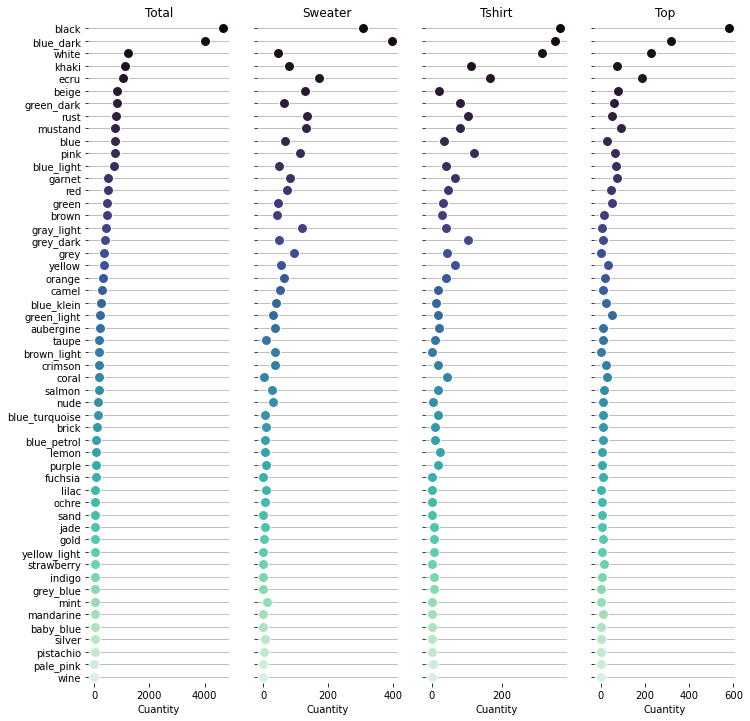

In [40]:
g = sns.PairGrid(dumificado.sort_values("total", ascending=False),
                 x_vars=dumificado.columns[-4:], y_vars=["color"],
                 height=10, aspect=.25)

g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="mako", linewidth=1, edgecolor="w")

g.set(xlabel="Cuantity", ylabel="")
titles = [x.capitalize() for x in dumificado.columns[-4:]]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

#### **Publicados por origen de marca (Spider)**

In [35]:
publishable = np.array([x[0] for x in df_total.select('publishable').collect()])
stock = np.array([x[0] for x in df_total.select('stock').collect()])

In [36]:
df_empresas_spider = pd.DataFrame()
df_empresas_spider['publishable'], df_empresas_spider['stock'], df_empresas_spider['brand_origin_brand'] = publishable, stock, brand_origin_brand
df_empresas_spider = df_empresas_spider.pivot_table(index = 'publishable', columns='brand_origin_brand', values = 'stock', aggfunc ='sum')
df_empresas_spider.reset_index(drop = True, inplace = True)

df_empresas_spider = ((df_empresas_spider.T / df_empresas_spider.sum(axis = 1))*100).T
df_empresas_spider = pd.concat([pd.Series(['No Published', 'Published']), df_empresas_spider], axis = 1).rename({0: 'group'}, axis = 1)

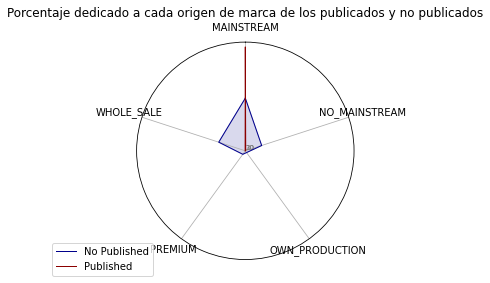

In [37]:
from math import pi

df_empresas_spider['group'] = df_empresas_spider['group'].astype('str')
categories = list(df_empresas_spider)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0)
plt.yticks([0.12,0.2,0.28], ["10","20","30"], color="grey", size=7)

 
color_list = ['darkblue', 'darkred', 'darkgreen']

for i in range(len(df_empresas_spider)):
    
    values = df_empresas_spider.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth = 1, linestyle='solid', label = df_empresas_spider.group[i], color = color_list[i])
    ax.fill(angles, values, color = color_list[i], alpha = 0.15)
    
plt.legend(loc = 'upper right', bbox_to_anchor = (0.1, 0.1))
plt.title('Porcentaje dedicado a cada origen de marca de los publicados y no publicados')
plt.show()

In [38]:
print('% de valores nulos en stock:', len(stock[stock == 0])/len(stock) * 100)

% de valores nulos en stock: 90.47837894297055


### **Analisis de la variable season**

In [39]:
def season(num, variable, dff):
    Season_9=dff[dff['season']==num]
    orden, orden1 = [], []
    for a in Season_9.rdd.collect(): orden.append(a[variable])
    for i in Season_9.rdd.collect(): orden1.append(i['count'])
    
    return Season_9, orden, orden1
    
def graficos_barras(paleta, orden, orden1, titulo):
    colores = paleta
    orden=orden[0:10]
    fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
    fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

    fig.update_layout(
        title=titulo,
        yaxis_title = 'Cantidad', font = dict(size = 22),
        paper_bgcolor='white',
        plot_bgcolor='white'
        # , width=2200, height=800
    )
    fig.show()

season_all_color = df.groupBy('season' , "color").count().orderBy("count", ascending=False)
season_all_product = df.groupBy('season' , 'family_product').count().orderBy("count", ascending=False)

##### Season 9

In [80]:
Season_9, orden, orden1 = season(9,'color', season_all_color)
Season_9, orden2, orden3 = season(9,'family_product', season_all_product)
df_prendas = pd.DataFrame()
df_prendas['prendas_9'], df_prendas['count_9'] = orden2[:10], orden3[:10]

graficos_barras(paleta[0], orden, orden1, 'Los colores que más se utilizan en la temporada 9')
graficos_barras(paleta[0], orden2, orden3, 'Los productos que más se utilizan en la temporada 9')

##### Season 8

In [81]:
Season_8, orden, orden1 = season(8,'color', season_all_color)
Season_8, orden2, orden3 = season(8,'family_product', season_all_product)
df_prendas['prendas_8'], df_prendas['count_8'] = orden2[:10], orden3[:10]

graficos_barras(paleta[0], orden, orden1, 'Los colores que más se utilizan en la temporada 8')
graficos_barras(paleta[0], orden2, orden3, 'Los productos que más se utilizan en la temporada 8')

##### Season 7

In [82]:
Season_7, orden, orden1 = season(7,'color', season_all_color)
Season_7, orden2, orden3 = season(7,'family_product', season_all_product)
df_prendas['prendas_7'], df_prendas['count_7'] = orden2[:10], orden3[:10]

graficos_barras(paleta[0], orden, orden1, 'Los colores que más se utilizan en la temporada 7')
graficos_barras(paleta[0], orden2, orden3, 'Los productos que más se utilizan en la temporada 7')

In [84]:
df_prendas.to_csv('df_prendas.csv')

### **Análisis de las marcas más usadas**

In [ ]:
marcas_color = df.groupBy('name_brand').count().orderBy("count", ascending=False)

orden, orden1 = [], []
for a in marcas_color.rdd.collect(): orden.append(a.name_brand)
for i in marcas_color.rdd.collect(): orden1.append(i['count'])
orden=orden[0:10]

graficos_barras(paleta[0], orden, orden1, 'Los colores que más se utilizan por marca')

In [ ]:
brand_product= df.groupBy('name_brand' , "family_product").count().orderBy("count", ascending=False)
brand_color= df.groupBy('name_brand' , "color").count().orderBy("count", ascending=False)

##### Marca 55

In [ ]:
def marca_ropa_atributos(df1, df2):
    orden = list(map(lambda x:x['family_product'] ,df1.rdd.collect()))
    orden1 = list(map(lambda x:x['count'] ,df1.rdd.collect()))
    orden2 = list(map(lambda x:x['color'] ,df2.rdd.collect()))
    orden3 = list(map(lambda x:x['count'] ,df2.rdd.collect()))

    return orden, orden1, orden2, orden3

In [ ]:

BRAND55_product, BRAND55_color = brand_product[brand_product['name_brand']=='BRAND55'], brand_color[brand_color['name_brand']=='BRAND55']
orden, orden1, orden2, orden3 = marca_ropa_atributos(BRAND55_product, BRAND55_color)
graficos_barras(paleta[0], orden, orden1, 'Las familias de productos que más se utilizan por marca BRAND55') 
graficos_barras(paleta[0], orden2, orden3, 'Los colores que más se utilizan por marca BRAND55')

##### Marca 119

In [ ]:
BRAND119_product, BRAND119_color = brand_product[brand_product['name_brand']=='BRAND119'], brand_color[brand_color['name_brand']=='BRAND119']
orden, orden1, orden2, orden3 = marca_ropa_atributos(BRAND119_product, BRAND119_color)
graficos_barras(paleta[0], orden, orden1, 'Las familias de productos que más se utilizan por marca BRAND119') 
graficos_barras(paleta[0], orden2, orden3, 'Los colores que más se utilizan por marca BRAND119')

##### Marca76

In [ ]:
BRAND76_product, BRAND76_product_color = brand_product[brand_product['name_brand']=='BRAND76'], brand_color[brand_color['name_brand']=='BRAND76']
orden, orden1, orden2, orden3 = marca_ropa_atributos(BRAND76_product, BRAND76_product_color)
graficos_barras(paleta[0], orden, orden1, 'Las familias de productos que más se utilizan por marca BRAND76') 
graficos_barras(paleta[0], orden2, orden3, 'Los colores que más se utilizan por marca BRAND76')

#### **Heatmaps**

In [ ]:
color = df_total.select('color').collect()
color = np.array([x[0] for x in color])
Season = df_total.select('size_lookiero').collect()
Season = np.array([x[0] for x in Season])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family_product'] = Season, color

hm_131_p = pd.get_dummies(df_heat, columns=['product_family_product']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_product_', '').capitalize() for x in hm_131_p.columns]
hm_131_p=hm_131_p.loc[:,['Blue_dark','White','Rust','Khaki','Ecru','Beige','Green_dark','Black','Mustand']]
hm_131_p=hm_131_p.iloc[0:3]

Text(0.5, 1.0, 'Relación entre Tallas y productos')

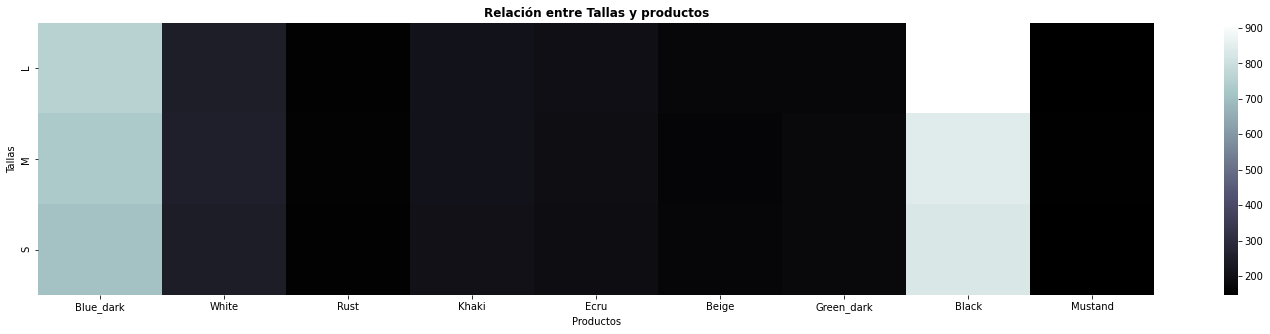

In [ ]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre Tallas y productos",fontweight='bold')

In [ ]:
color = df_total.select('color').collect()
color = np.array([x[0] for x in color])
Season = df_total.select('family_product').collect()
Season = np.array([x[0] for x in Season])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['family_product'] = Season, color

hm_131_p = pd.get_dummies(df_heat, columns=['family_product']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('family_product_', '').capitalize() for x in hm_131_p.columns]
hm_131_p=hm_131_p.loc[:,['Blue_dark','White','Rust','Khaki','Ecru','Beige','Green_dark','Black','Mustand']]
hm_131_p=hm_131_p.iloc[[13,-1,-3,7,4,10,5,-6]]

Text(0.5, 1.0, 'Relación entre Tallas y productos')

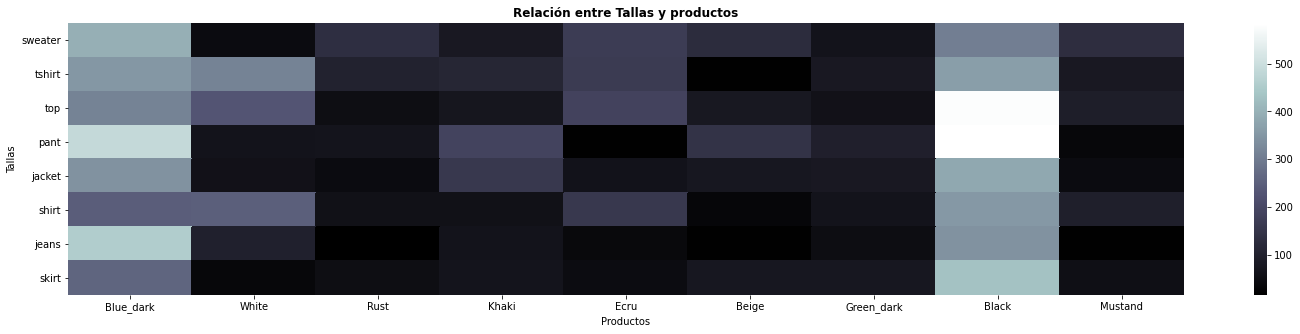

In [ ]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre Tallas y productos",fontweight='bold')

In [ ]:
color = df_total.select('name_brand').collect()
color = np.array([x[0] for x in color])
Season = df_total.select('size_lookiero').collect()
Season = np.array([x[0] for x in Season])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['family_product'] = Season, color

hm_131_p = pd.get_dummies(df_heat, columns=['family_product']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('family_product_', '').capitalize() for x in hm_131_p.columns]
hm_131_p=hm_131_p.loc[:,['Brand55','Brand119','Brand76','Brand89','Brand15','Brand102','Brand83','Brand142','Brand66']]
hm_131_p=hm_131_p.iloc[0:3]

Text(0.5, 1.0, 'Relación entre Tallas y productos')

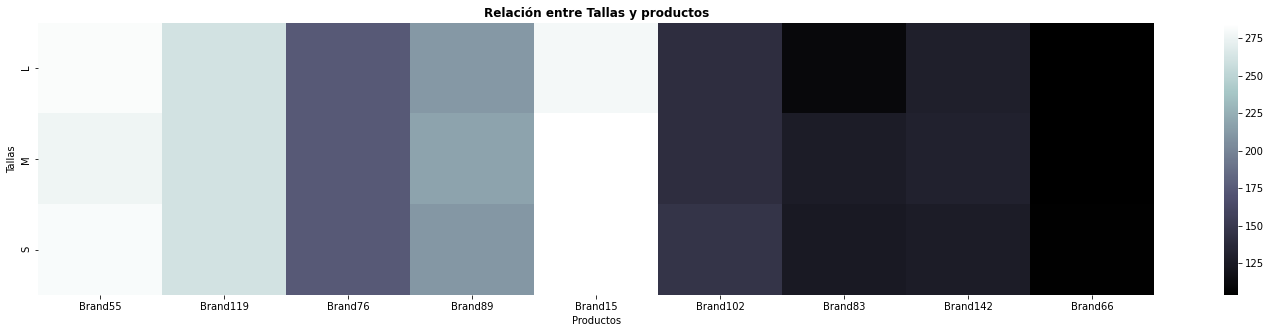

In [ ]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre Tallas y productos",fontweight='bold')

---